# Quantam Data Part (Orginal Paper)

# Ignore Warning

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Save Figure

In [4]:
# Save figure function
import os
from pathlib import Path
from matplotlib import pyplot as plt
IMAGES_PATH = Path() / "IMAGES" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
'''


Electronic structure problem with classical shadows, as presented in https://arxiv.org/abs/2103.07510
This code uses Qiskit as platform. 
'''

import time
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, execute
from qiskit_aer import QasmSimulator

from qiskit.quantum_info import SparsePauliOp

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import BravyiKitaevMapper, JordanWignerMapper, ParityMapper

from qiskit.circuit.library import TwoLocal

from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP, COBYLA, SPSA

# Estimator primitive is based on the Statevector construct = algebraic simulation
from qiskit.primitives import Estimator 

from modified_derandomization import modified_derandomized_classical_shadow
from data_acquisition_shadow import derandomized_classical_shadow
from prediction_shadow import estimate_exp

import qiskit_nature
qiskit_nature.settings.use_pauli_sum_op = False
import h5py
H5PY_DEFAULT_READONLY=1





driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="6-31g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

problem = driver.run()

hamiltonian = problem.hamiltonian
second_q_op = hamiltonian.second_q_op()

mapper = JordanWignerMapper()
bkencoded_hamiltonian = mapper.map(second_q_op)

#print(bkencoded_hamiltonian)

In [6]:
def process_hamiltonian(hamiltonian, derandomize = False):

    hamiltonian_observables = []
    hamiltonian_coefficients = []

    for observable in hamiltonian.paulis:
        op_list = []
        for op_index, pauli_op in enumerate(observable):
            pauli_op = str(pauli_op)
            if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
                op_list.append((pauli_op, op_index))
        hamiltonian_observables.append(op_list)
    
    hamiltonian_coefficients = hamiltonian.coeffs.real
    
    system_size = len(hamiltonian_observables[0])

    # removing all occurrences of Pauli-I, for all-Pauli-I there is an empty list left
    # these observables are needed for estimate_exp()
    observables_xyze = []

    for observable in hamiltonian_observables:
        XYZE = []
        for pauli in observable:
            if pauli[0] != 'I':
                XYZE.append(pauli)
        observables_xyze.append(XYZE)   
    
    # derandomisation procedure requires that coefficients are non-negative
    if derandomize == True:
        absolute_coefficients = [abs(coeffcient) for coeffcient in hamiltonian_coefficients]

        # removing the empty list as well
        # these observables are needed for derandomisation procedure
        observables_xyz = []
        for idx, observable in enumerate(observables_xyze):
            if observable:
                observables_xyz.append(observable)
            else:
                absolute_coefficients.pop(idx)
        
        return system_size, observables_xyze, observables_xyz, hamiltonian_coefficients, absolute_coefficients
    
    return system_size, observables_xyze, hamiltonian_coefficients



# process the Hamiltonian to obtain properly formatted data
hamiltonian_data = process_hamiltonian(bkencoded_hamiltonian, derandomize = True)
system_size, observables_xyze, observables_xyz, hamiltonian_coefficients, absolute_coefficients = hamiltonian_data

#print('HAMILTONIAN\n', observables_xyze)

In [7]:
'''
VARIATIONAL ANSATZ
Note that for molecules other than H_2 you may need to specify a different number of reps.
'''

reps = 5
ansatz = TwoLocal(num_qubits=system_size, reps=reps, rotation_blocks=['ry', 'rz'],
                entanglement_blocks='cz', skip_final_rotation_layer=False)
ansatz.decompose().draw('mpl')






def basis_change_circuit(pauli_op):

    #   Generating circuit with just the basis change operators
    #
    #       pauli_op: n-qubit Pauli operator

    basis_change = QuantumCircuit(ansatz.num_qubits, ansatz.num_qubits)

    for idx, op in enumerate(pauli_op):
        
        if op == 'X':
            basis_change.h(idx)
        if op == 'Y':
            basis_change.h(idx)
            basis_change.p(-np.pi/2, idx)
            
    return basis_change

    
    


def ground_state_energy_from_shadow(operators, params):
    
    backend = QasmSimulator(method='statevector', shots=1)
    
    pauli_op_dict = Counter(tuple(x) for x in operators)    
    
    
    shadow = []
    for pauli_op in pauli_op_dict:
        
        qc = ansatz.bind_parameters(params)
        qc = qc.compose(basis_change_circuit(pauli_op))                                   # changed
        qc.measure(reversed(range(system_size)), range(system_size))                      # changed
        
        result = execute(qc, backend, shots=pauli_op_dict[pauli_op]).result()
        counts = result.get_counts()    # given in order q0 q1 ... qn-1 after reversal in qc.measure
        
        for count in counts:
            for _ in range(counts[count]): # number of repeated measurement values

                output_str = list(count)   
                output = [int(i) for i in output_str]
                eigenvals = [x+1 if x == 0 else x-2 for x in output]
                snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
                
                shadow.append(snapshot)
    
    
    expectation_value = 0.0
    for term, weight in zip(observables_xyze, hamiltonian_coefficients):
        
        sum_product, match_count = estimate_exp(shadow, term)
        
        if match_count != 0:
            expectation_value += (weight * sum_product / match_count)

    return expectation_value
      

In [8]:
'''
Running VQE on the Hamiltonian obtained from PySCFDriver using Statevector simulator (Estimator primitive)
'''

estimator = Estimator()
# If shots = None, it calculates the exact expectation values. Otherwise, it samples from normal distributions 
# with standard errors as standard deviations using normal distribution approximation.
estimator.set_options(shots = None)
vqe_solver = VQE(estimator, ansatz, SLSQP(maxiter=3000))

calc = GroundStateEigensolver(mapper, vqe_solver)
result = calc.solve(problem)
print(result.raw_result)

{   'aux_operators_evaluated': {   'AngularMomentum': (   0.0021052882431932124,
                                                          {}),
                                   'Magnetization': (2.362166735267457e-05, {}),
                                   'ParticleNumber': (2.0001747907604797, {}),
                                   'XDipole': (0.0, {}),
                                   'YDipole': (0.0, {}),
                                   'ZDipole': (1.3891998742217622, {})},
    'cost_function_evals': 12615,
    'eigenvalue': -1.8621558183097635,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7fd2b51f6b10>,
    'optimal_parameters': {   ParameterVectorElement(θ[4]): 4.697186287616914,
                              ParameterVectorElement(θ[5]): -0.0007055944813971808,
                              ParameterVectorElement(θ[6]): 0.0003182008491444386,
                              ParameterVectorElement(θ[7]): -0.0001622265536802884,
     

NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR

EXPERIMENT 0: GROUND STATE ENERGY FOUND = 1.5186894014690122
EXPERIMENT 1: GROUND STATE ENERGY FOUND = 1.5257691953259722
EXPERIMENT 2: GROUND STATE ENERGY FOUND = 1.52747731609589
EXPERIMENT 3: GROUND STATE ENERGY FOUND = 1.5204909886817506
EXPERIMENT 4: GROUND STATE ENERGY FOUND = 1.510180965762622
EXPERIMENT 5: GROUND STATE ENERGY FOUND = 1.5119042924204467
EXPERIMENT 6: GROUND STATE ENERGY FOUND = 1.5138798274842078
EXPERIMENT 7: GROUND STATE ENERGY FOUND = 1.521822277643665
EXPERIMENT 8: GROUND STATE ENERGY FOUND = 1.523382617171121
EXPERIMENT 9: GROUND STATE ENERGY FOUND = 1.52012267022365
50 | Counter({('X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'): 50}) | 3.381532230048045
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -0.37843626532356883
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -0.37427418564315024
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -0.3766871487826328
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -0.3833139039760039

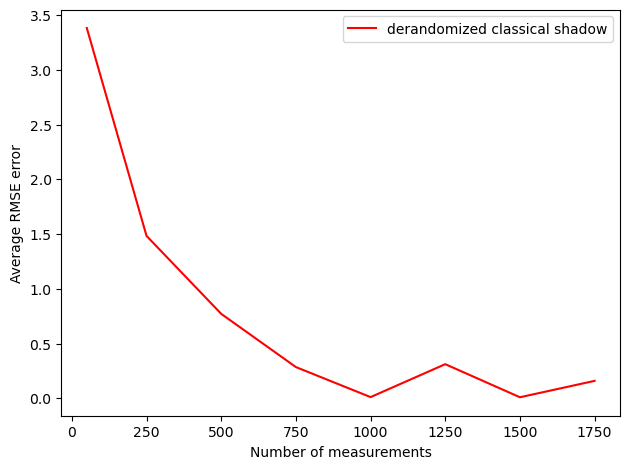

In [9]:
'''
EXPERIMENTS
'''

start_time = time.time()
rmse_errors = []




print('NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR\n')
measurement_range = [50, 250, 500, 750, 1000, 1250, 1500, 1750]

for num_operators in measurement_range:   
    
    derandomized_hamiltonian = modified_derandomized_classical_shadow(observables_xyz, num_operators, 
                                                                      system_size, weight=absolute_coefficients)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    
    expectation_values = []
    test = []
    
    num_experiments = 10


    for iteration in range(num_experiments):
        
        expectation_value = ground_state_energy_from_shadow(derandomized_hamiltonian, result.raw_result.optimal_point)
        expectation_values.append(expectation_value)
        
        test.append (expectation_value)
                
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, expectation_value))


    rmse_derandomised_cs = np.sqrt(np.sum([(expectation_values[i] - result.raw_result.optimal_value)**2 
                                           for i in range(num_experiments)])/num_experiments)

    rmse_errors.append(rmse_derandomised_cs)
    
    print('{} | {} | {}'.format(num_operators, counts, rmse_derandomised_cs))


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

          
points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'r', label='derandomized classical shadow')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)

save_fig("Derandomize classical shadow graph")


In [10]:
'''
ESTIMATE THE HAMILTONIAN ON OPTIMAL PARAMETERS
'''

qc = ansatz.bind_parameters(result.raw_result.optimal_point)
job_ham = estimator.run(qc, bkencoded_hamiltonian)
result_h = job_ham.result()
print(f">>> Expectation value of the Hamiltonian: {result_h.values[0]}")

store_term = []
store_coff = []


expectation_values = []
for index, term in enumerate(bkencoded_hamiltonian.paulis):
    job = estimator.run(qc, term) 
    #print(f">>> Job ID: {job.job_id()}")
    #print(f">>> Job Status: {job.status()}")
    result2 = job.result()
    #print(f">>> {result2}")
    expval = result2.values[0]
    expectation_values.append(expval)
    print("  > Expectation value of {} with coeff {}: {}".format(term, bkencoded_hamiltonian.coeffs.real[index], expval))
    store_term.append(term)
    
    store_coff.append(bkencoded_hamiltonian.coeffs.real[index])
    
    
    
total_expval = 0.0
for index, expval in enumerate(expectation_values):
    total_expval += expval * bkencoded_hamiltonian.coeffs.real[index]

print('>>> Total expectation value from summing up expectation values of all terms', total_expval)

>>> Expectation value of the Hamiltonian: -1.8621558183097635
  > Expectation value of IIIIIIII with coeff 1.5280210592332617: 1.0000000000000002
  > Expectation value of IIIIIIIZ with coeff -0.272215257351005: -0.9797401015107768
  > Expectation value of IIIIIYZY with coeff 0.08812294324841644: -0.00035590780930308416
  > Expectation value of IIIIIXZX with coeff 0.08812294324841644: -0.0003575965136561271
  > Expectation value of IIIIIIZI with coeff -0.40516889844632475: 0.9853167759412688
  > Expectation value of IIIIYZYI with coeff -0.05206368066441218: 0.009952760199946195
  > Expectation value of IIIIXZXI with coeff -0.05206368066441218: -0.01011944207812752
  > Expectation value of IIIIIZII with coeff -0.6893596033215872: 0.9942686216440318
  > Expectation value of IIIIZIII with coeff -1.0422225890818173: 0.9999326698302917
  > Expectation value of IIIZIIII with coeff -0.272215257351005: -0.9797372581051386
  > Expectation value of IYZYIIII with coeff 0.08812294324841641: -6.8355

# Classical ML (Extension of paper)

# Dataset Creation

In [11]:
import numpy as np

In [12]:
store_term

[Pauli('IIIIIIII'),
 Pauli('IIIIIIIZ'),
 Pauli('IIIIIYZY'),
 Pauli('IIIIIXZX'),
 Pauli('IIIIIIZI'),
 Pauli('IIIIYZYI'),
 Pauli('IIIIXZXI'),
 Pauli('IIIIIZII'),
 Pauli('IIIIZIII'),
 Pauli('IIIZIIII'),
 Pauli('IYZYIIII'),
 Pauli('IXZXIIII'),
 Pauli('IIZIIIII'),
 Pauli('YZYIIIII'),
 Pauli('XZXIIIII'),
 Pauli('IZIIIIII'),
 Pauli('ZIIIIIII'),
 Pauli('IIIIIIZZ'),
 Pauli('IIIIYZYZ'),
 Pauli('IIIIXZXZ'),
 Pauli('IIIIIYIY'),
 Pauli('IIIIIXIX'),
 Pauli('IIIIYXXY'),
 Pauli('IIIIYYYY'),
 Pauli('IIIIXXYY'),
 Pauli('IIIIYYXX'),
 Pauli('IIIIXXXX'),
 Pauli('IIIIXYYX'),
 Pauli('IIIIIZIZ'),
 Pauli('IIIIZIIZ'),
 Pauli('IIIIZYZY'),
 Pauli('IIIIZXZX'),
 Pauli('IIIZIIIZ'),
 Pauli('IIIZIYZY'),
 Pauli('IIIZIXZX'),
 Pauli('IIYYIIYY'),
 Pauli('IIXXIIYY'),
 Pauli('IIYYIIXX'),
 Pauli('IIXXIIXX'),
 Pauli('IIYYYZZY'),
 Pauli('IIXXYZZY'),
 Pauli('IIYYXZZX'),
 Pauli('IIXXXZZX'),
 Pauli('IYZYIIIZ'),
 Pauli('IXZXIIIZ'),
 Pauli('IYZYIYZY'),
 Pauli('IXZXIYZY'),
 Pauli('IYZYIXZX'),
 Pauli('IXZXIXZX'),
 Pauli('YZZYIIYY'),


In [13]:
store_coff

[1.5280210592332617,
 -0.272215257351005,
 0.08812294324841644,
 0.08812294324841644,
 -0.40516889844632475,
 -0.05206368066441218,
 -0.05206368066441218,
 -0.6893596033215872,
 -1.0422225890818173,
 -0.272215257351005,
 0.08812294324841641,
 0.08812294324841641,
 -0.40516889844632475,
 -0.05206368066441219,
 -0.05206368066441219,
 -0.6893596033215873,
 -1.0422225890818178,
 0.0885220615853347,
 0.016033305580190987,
 0.016033305580190987,
 -0.017356000955093313,
 -0.017356000955093313,
 -0.012970529275601935,
 -0.015318666338180915,
 -0.0023481370625789686,
 -0.0023481370625789686,
 -0.015318666338180915,
 -0.012970529275601935,
 0.105719993308319,
 0.1317993452115655,
 -0.01983190481381173,
 -0.01983190481381173,
 0.16302461641468569,
 -0.04197705526657951,
 -0.04197705526657951,
 0.019862079551633466,
 0.019862079551633466,
 0.019862079551633466,
 0.019862079551633466,
 -0.019808855464805167,
 -0.019808855464805167,
 -0.019808855464805167,
 -0.019808855464805167,
 -0.041977055266579

In [14]:
expectation_values

[1.0000000000000002,
 -0.9797401015107768,
 -0.00035590780930308416,
 -0.0003575965136561271,
 0.9853167759412688,
 0.009952760199946195,
 -0.01011944207812752,
 0.9942686216440318,
 0.9999326698302917,
 -0.9797372581051386,
 -6.835539737133938e-05,
 -6.877766023500445e-05,
 0.9894644333351047,
 -0.012264754669859353,
 -0.0007950483744027159,
 0.994269764274676,
 0.9958755130695844,
 -0.9941998541875999,
 -0.010061374857575146,
 0.009895875042923498,
 -0.0003575448033910512,
 -0.000355961294501942,
 -4.924472221647585e-06,
 -2.189767585544317e-06,
 -4.861824131588091e-06,
 4.895639765114299e-06,
 2.2254143358169403e-06,
 4.875070636046509e-06,
 -0.9853849102996787,
 -0.9796741802715534,
 -0.00035587914134150173,
 -0.00035756806415167226,
 0.9999960121918315,
 0.00036709532077920534,
 0.0003657818732178168,
 -0.14401638330137223,
 -0.14405686704214946,
 -0.14459157020283936,
 -0.14350421585138476,
 0.001548045815792643,
 0.0015500188666952629,
 9.313476789874114e-05,
 9.367345925924242e

In [15]:
array2 = np.array (store_coff)
array3 = np.array (expectation_values)

In [16]:
import pandas as pd
# read text file into pandas DataFrame
array1 = pd.read_csv("pauli.txt", sep="\t")

# display DataFrame
print(array1)
# array1.to_csv('file2.csv')

     [IIIIIIII,
0     IIIIIIIZ,
1     IIIIIYZY,
2     IIIIIXZX,
3     IIIIIIZI,
4     IIIIYZYI,
..          ...
179   IZZIIIII,
180   YIYIIIII,
181   XIXIIIII,
182   ZIZIIIII,
183   ZZIIIIII]

[184 rows x 1 columns]


In [17]:
df = pd.read_csv('file2.csv')
array1 = df.to_numpy()

In [18]:
print(array1)

[[' IIIIIIIZ,']
 [' IIIIIYZY,']
 [' IIIIIXZX,']
 [' IIIIIIZI,']
 [' IIIIYZYI,']
 [' IIIIXZXI,']
 [' IIIIIZII,']
 [' IIIIZIII,']
 [' IIIZIIII,']
 [' IYZYIIII,']
 [' IXZXIIII,']
 [' IIZIIIII,']
 [' YZYIIIII,']
 [' XZXIIIII,']
 [' IZIIIIII,']
 [' ZIIIIIII,']
 [' IIIIIIZZ,']
 [' IIIIYZYZ,']
 [' IIIIXZXZ,']
 [' IIIIIYIY,']
 [' IIIIIXIX,']
 [' IIIIYXXY,']
 [' IIIIYYYY,']
 [' IIIIXXYY,']
 [' IIIIYYXX,']
 [' IIIIXXXX,']
 [' IIIIXYYX,']
 [' IIIIIZIZ,']
 [' IIIIZIIZ,']
 [' IIIIZYZY,']
 [' IIIIZXZX,']
 [' IIIZIIIZ,']
 [' IIIZIYZY,']
 [' IIIZIXZX,']
 [' IIYYIIYY,']
 [' IIXXIIYY,']
 [' IIYYIIXX,']
 [' IIXXIIXX,']
 [' IIYYYZZY,']
 [' IIXXYZZY,']
 [' IIYYXZZX,']
 [' IIXXXZZX,']
 [' IYZYIIIZ,']
 [' IXZXIIIZ,']
 [' IYZYIYZY,']
 [' IXZXIYZY,']
 [' IYZYIXZX,']
 [' IXZXIXZX,']
 [' YZZYIIYY,']
 [' XZZXIIYY,']
 [' YZZYIIXX,']
 [' XZZXIIXX,']
 [' YZZYYZZY,']
 [' XZZXYZZY,']
 [' YZZYXZZX,']
 [' XZZXXZZX,']
 [' IIZIIIIZ,']
 [' IIZIIYZY,']
 [' IIZIIXZX,']
 [' IYYIIIYY,']
 [' IXXIIIYY,']
 [' IYYIIIXX,']
 [' IXXI

In [19]:
import pandas as pd

df = pd.DataFrame({'Coefficient': array2,
                   'Expectation Values': array3,
                   })

# df['Paulies'] = df.apply(lambda s: s.to_numpy(), axis=1)

print(df)

     Coefficient  Expectation Values
0       1.528021            1.000000
1      -0.272215           -0.979740
2       0.088123           -0.000356
3       0.088123           -0.000358
4      -0.405169            0.985317
..           ...                 ...
180     0.086215            0.983795
181     0.023950           -0.012335
182     0.023950           -0.000800
183     0.093777            0.985383
184     0.106564            0.990169

[185 rows x 2 columns]


In [20]:
df.to_csv('file1.csv')

# Figure save function

In [21]:
# Save figure function
import os
from pathlib import Path
from matplotlib import pyplot as plt
IMAGES_PATH = Path() / "IMAGES" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Import Libraries

In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
df = pd.read_csv('Classical_data_H2.csv')
df.head(100)

Pauli Operators  Coefficient  Expectation Values
0         IIIIIIII     1.528021            1.000000
1         IIIIIIIZ    -0.272215           -0.981762
2         IIIIIYZY     0.088123            0.004820
3         IIIIIXZX     0.088123            0.004774
4         IIIIIIZI    -0.405169            0.985584
..             ...          ...                 ...
95        IIYYIYYI    -0.004951           -0.000030
96        IIXXIYYI    -0.004951           -0.000030
97        IIYYIXXI    -0.004951           -0.000654
98        IIXXIXXI    -0.004951           -0.000655
99        IYZYIIZI    -0.012405            0.000753

[100 rows x 3 columns]

# Generate informaion about dataset

In [24]:
from ydata_profiling import ProfileReport
from ydata_profiling.utils.cache import cache_file
report=ProfileReport(
    df,title="Quality_Test", explorative=True)
report.to_file("dataset_before_applyinig_smagon.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Discover and Visualize the Data to Gain Insights

In [25]:
df['Pauli Operators'].value_counts()

Pauli Operators
IIIIIIII     1
 YYIIIXXI    1
 YZYIYZYI    1
 XZXIYZYI    1
 YZYIXZXI    1
            ..
 IYYIYZZY    1
 IXXIYZZY    1
 IYYIXZZX    1
 IXXIXZZX    1
 ZZIIIIII    1
Name: count, Length: 185, dtype: int64

In [26]:
df['Coefficient'].value_counts()

Coefficient
-0.005281    8
 0.030721    8
-0.000517    8
-0.004951    8
-0.018251    8
-0.020600    8
-0.019809    8
 0.034558    4
 0.035842    4
-0.029954    4
 0.023950    4
-0.050553    4
 0.031606    4
 0.013600    4
 0.009022    4
 0.016784    4
 0.024467    4
 0.041922    4
 0.027407    4
-0.012405    4
 0.019862    4
-0.002348    4
 0.088123    4
-0.052064    4
 0.016033    4
-0.017356    4
-0.041977    4
-0.015319    4
-0.012971    4
-0.019832    4
 0.105720    2
 0.133127    2
 0.108384    2
 0.110560    2
-0.405169    2
 0.095237    2
-0.689360    2
-1.042223    2
 0.088522    2
 0.138170    2
 0.093777    2
-0.272215    2
 0.086215    2
 0.166357    2
 0.131799    2
 0.106564    2
 0.115864    1
 1.528021    1
 0.096381    1
 0.163025    1
 0.185777    1
Name: count, dtype: int64

In [27]:
df['Expectation Values'].value_counts()

Expectation Values
 1.000000e+00    1
 2.260000e-06    1
 1.241479e-02    1
 9.300000e-05    1
 9.280000e-05    1
                ..
-4.610000e-07    1
-1.250000e-06    1
 1.790000e-06    1
-3.530000e-07    1
 9.918790e-01    1
Name: count, Length: 185, dtype: int64

# Visualize the Data

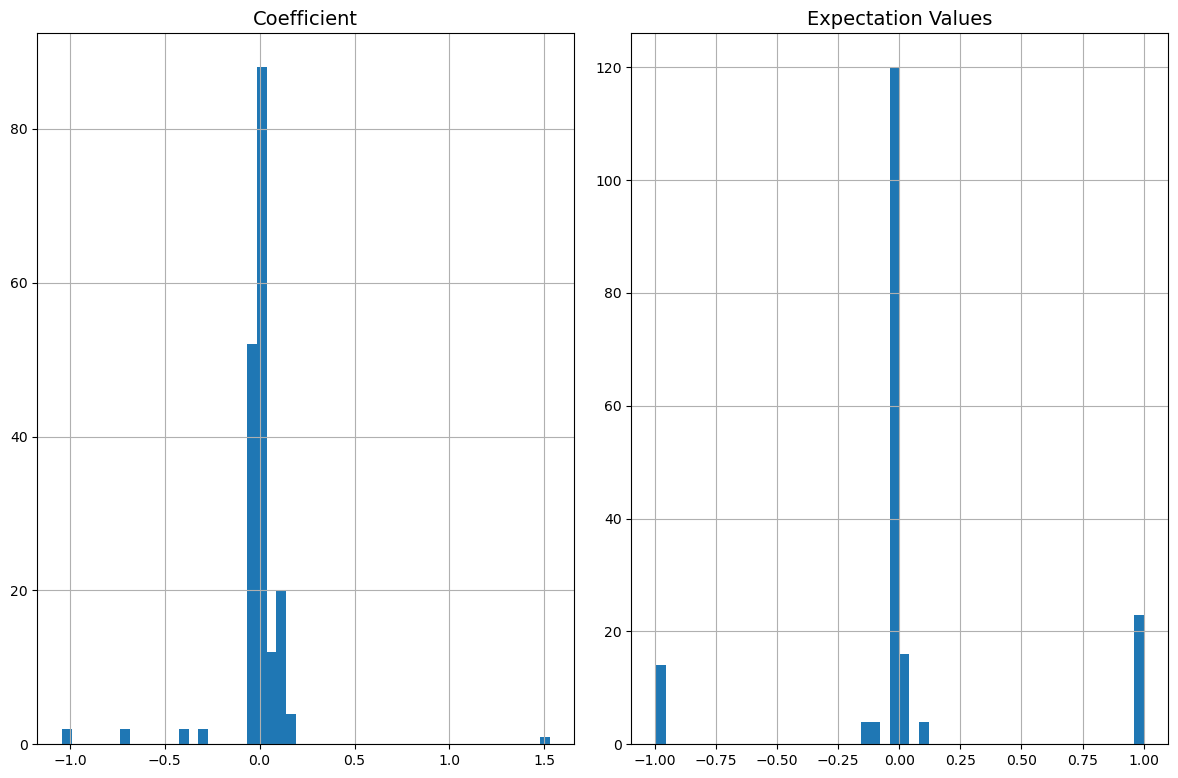

In [28]:
# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
df.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

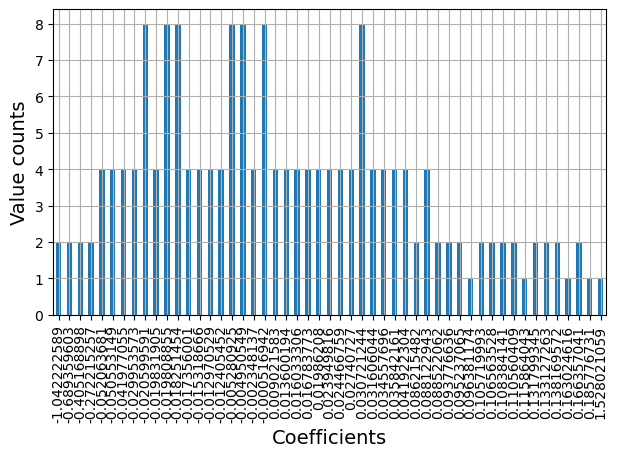

In [29]:
df['Coefficient'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Coefficients")
plt.ylabel("Value counts")
save_fig("Coefficients vs nuber of values")  # extra code
plt.xticks(rotation=90)
save_fig("Coefficients vs nuber of values_bar_plot")
plt.show()

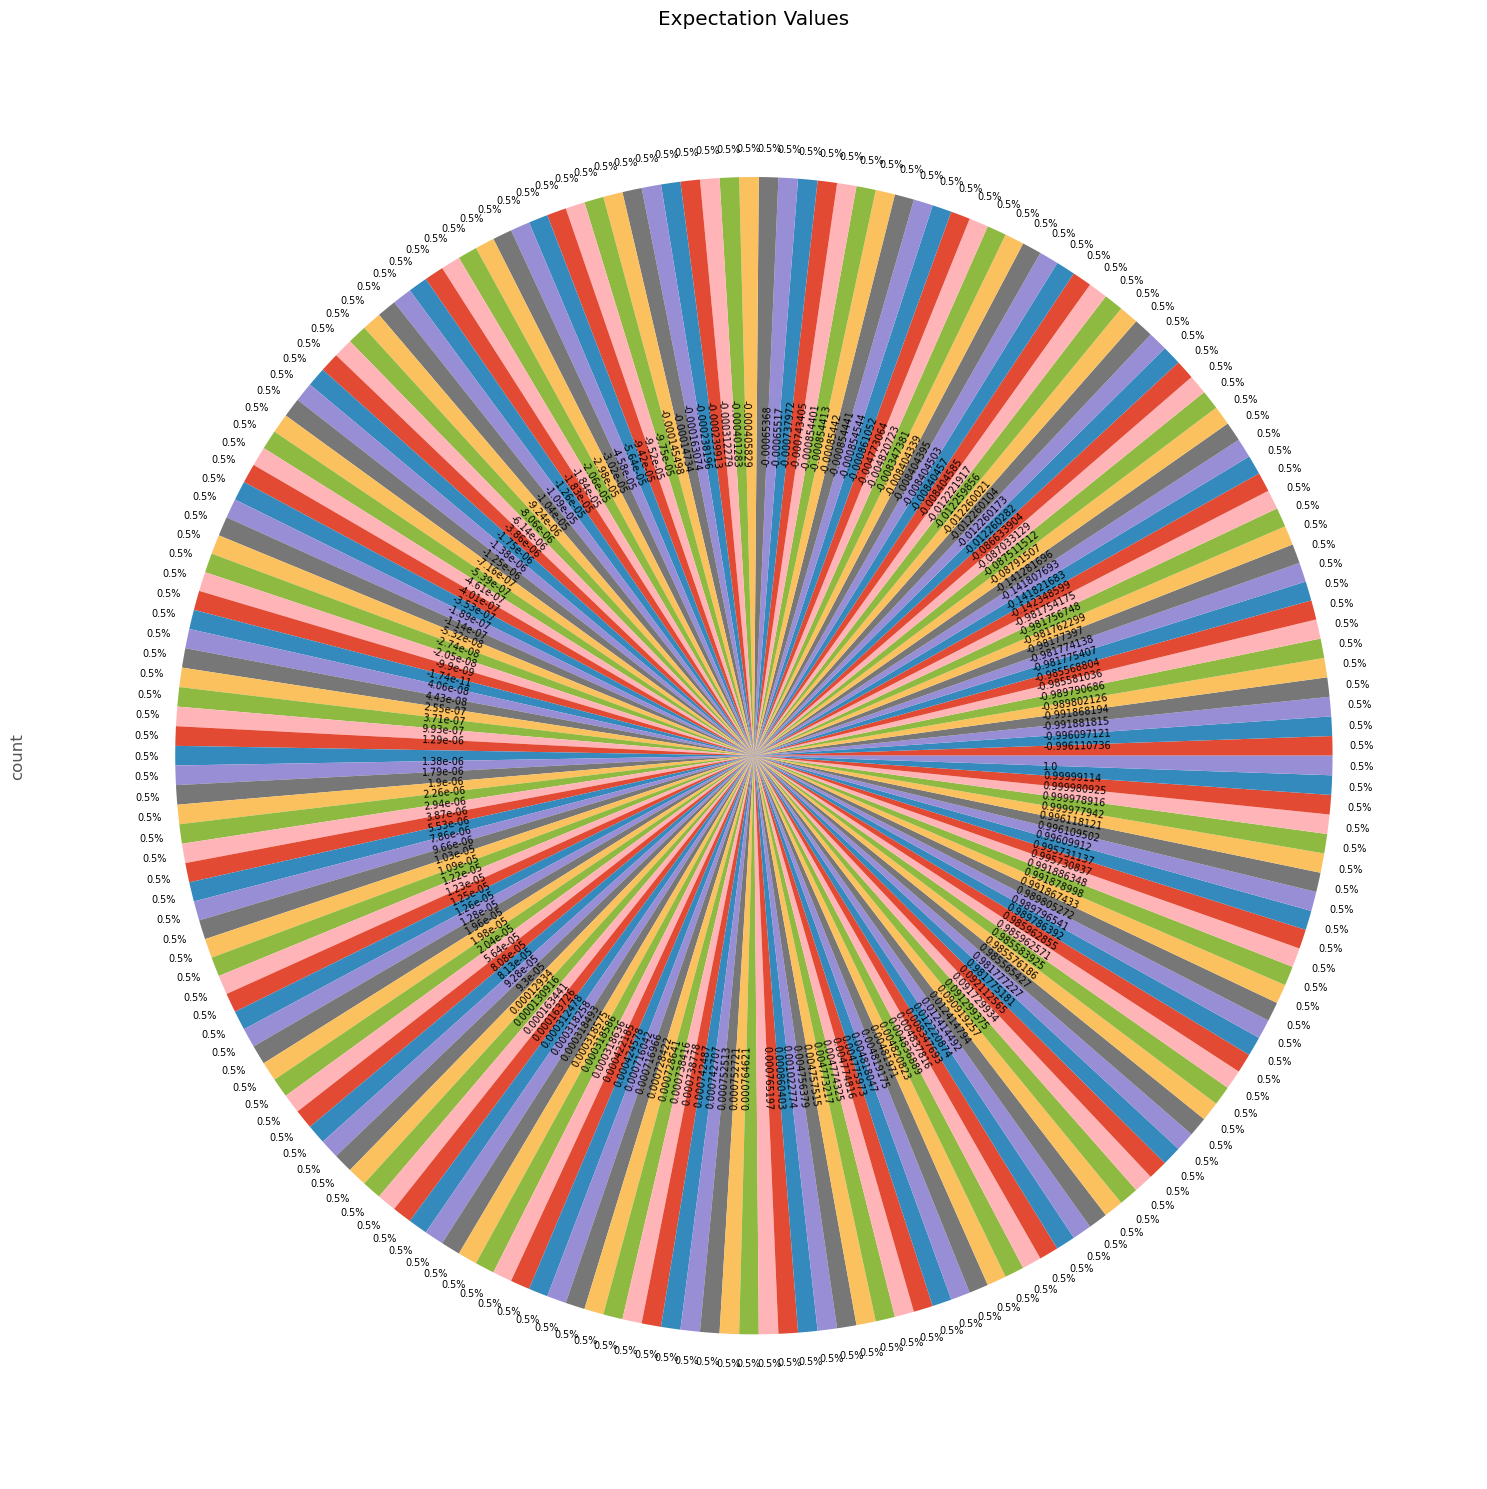

In [30]:
plt.style.use('ggplot')
plot = df['Expectation Values'].value_counts().sort_index().plot.pie(textprops={'size': 'x-small'},autopct='%1.1f%%',pctdistance=1.05,rotatelabels = 290,labeldistance=.5);
plt.title('Expectation Values')
fig = plt.gcf();
fig.set_size_inches(15,15);
save_fig("Expectation Values_pie_plot")

# Information about data types

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pauli Operators     185 non-null    object 
 1   Coefficient         185 non-null    float64
 2   Expectation Values  185 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.5+ KB


### Check data types of dataframe

In [32]:
df.dtypes

Pauli Operators        object
Coefficient           float64
Expectation Values    float64
dtype: object

In [33]:
df.describe()

Coefficient  Expectation Values
count   185.000000          185.000000
mean      0.001103            0.045530
std       0.187362            0.442551
min      -1.042223           -0.996111
25%      -0.018251           -0.000406
50%      -0.000517            0.000001
75%       0.031606            0.000765
max       1.528021            1.000000

In [34]:
df.shape

(185, 3)

In [35]:
# Unique Values 
df.nunique()

Pauli Operators       185
Coefficient            51
Expectation Values    185
dtype: int64

In [36]:
df.columns

Index(['Pauli Operators', 'Coefficient', 'Expectation Values'], dtype='object')

In [37]:
df.head(185)

Pauli Operators  Coefficient  Expectation Values
0          IIIIIIII     1.528021            1.000000
1          IIIIIIIZ    -0.272215           -0.981762
2          IIIIIYZY     0.088123            0.004820
3          IIIIIXZX     0.088123            0.004774
4          IIIIIIZI    -0.405169            0.985584
..              ...          ...                 ...
180        IZZIIIII     0.086215            0.989797
181        YIYIIIII     0.023950           -0.012260
182        XIXIIIII     0.023950           -0.000854
183        ZIZIIIII     0.093777            0.981775
184        ZZIIIIII     0.106564            0.991879

[185 rows x 3 columns]

# Feature Scaling

In [38]:
from sklearn.preprocessing import MinMaxScaler
scale_vars = ['Coefficient', 'Expectation Values']
scaler = MinMaxScaler()
df[scale_vars] = scaler.fit_transform(df[scale_vars])

In [39]:
df.head(185)

Pauli Operators  Coefficient  Expectation Values
0          IIIIIIII     1.000000            1.000000
1          IIIIIIIZ     0.299585            0.007188
2          IIIIIYZY     0.439781            0.501440
3          IIIIIXZX     0.439781            0.501418
4          IIIIIIZI     0.247857            0.992778
..              ...          ...                 ...
180        IZZIIIII     0.439039            0.994888
181        YIYIIIII     0.414814            0.492884
182        XIXIIIII     0.414814            0.498598
183        ZIZIIIII     0.441981            0.990870
184        ZZIIIIII     0.446956            0.995932

[185 rows x 3 columns]

In [40]:
df['Expectation Values']

0      1.000000
1      0.007188
2      0.501440
3      0.501418
4      0.992778
         ...   
180    0.994888
181    0.492884
182    0.498598
183    0.990870
184    0.995932
Name: Expectation Values, Length: 185, dtype: float64

In [41]:
df.shape

(185, 3)

# Convertion of catagorical to numerical data

## One hot encoder

In [42]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer

# catagorical_features = ["Pauli Operators"]

# # Instantiate the encoder
# one_hot = OneHotEncoder()

# transformer = ColumnTransformer([("one_hot", one_hot, 
#                                  catagorical_features)], remainder = "passthrough")

# transformed_X = transformer.fit_transform(df)


# transformed_X 

In [43]:
# print (transformed_X)

In [44]:
# transformed_X = pd.DataFrame.sparse.from_spmatrix(transformed_X)

## TF-IDF Vectorizer

In [45]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer


catagorical_features = df['Pauli Operators']

data = pd.DataFrame({'Text': catagorical_features})

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the text data
tfidf_vectors = vectorizer.fit_transform(data['Text'])

# Convert the TF-IDF vectors to a DataFrame
tfidf_df = pd.DataFrame(tfidf_vectors.toarray(), columns=vectorizer.get_feature_names_out())

# Print the TF-IDF DataFrame
tfidf_df.head()


# Cofficients
df2 = df.drop(columns = 'Pauli Operators') 

# Combine dataframe
transformed_X = pd.concat([tfidf_df, df2], axis=1, join='inner')

## Dataframe after converting categorical to numarical value

In [46]:
print(transformed_X)

     iiiiiiii  iiiiiiiz  iiiiiizi  iiiiiizz  iiiiixix  iiiiixzx  iiiiiyiy  \
0         1.0       0.0       0.0       0.0       0.0       0.0       0.0   
1         0.0       1.0       0.0       0.0       0.0       0.0       0.0   
2         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3         0.0       0.0       0.0       0.0       0.0       1.0       0.0   
4         0.0       0.0       1.0       0.0       0.0       0.0       0.0   
..        ...       ...       ...       ...       ...       ...       ...   
180       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
181       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
182       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
183       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
184       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

     iiiiiyzy  iiiiizii  iiiiiziz  ...  ziiixzxi  ziiiyzyi  ziiiziii  \
0  

In [47]:
df = transformed_X

# Balance the imbalance dataset (By undersampling)

In [48]:
# df = df.sparse.to_dense()

In [49]:
# import libaries
import smogn
import pandas

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
## conduct smogn
df_smogn = smogn.smoter(

    data = df, 
    y = "Expectation Values"
)

r_index: 100%|##########| 5/5 [00:00<00:00, 100.96it/s]


In [52]:
print (df_smogn)

    iiiiiiii  iiiiiiiz  iiiiiizi  iiiiiizz  iiiiixix  iiiiixzx  iiiiiyiy  \
0   0.000000  0.000000  0.000000  0.000000  0.000527  0.000601  0.000000   
1   0.002081  0.000000  0.000000  0.000000  0.002596  0.000000  0.002864   
2   0.000000  0.000000  0.001186  0.000000  0.000000  0.000000  0.002659   
3   0.000000  0.000000  0.001536  0.000000  0.002816  0.002720  0.000147   
4   0.004067  0.000000  0.002472  0.000000  0.000000  0.000000  0.000000   
..       ...       ...       ...       ...       ...       ...       ...   
11  0.000000  0.003530  0.000000  0.000042  0.000000  0.000000  0.000000   
12  0.000000  0.000686  0.000000  0.004470  0.000000  0.000000  0.000000   
13  0.000000  0.001691  0.000000  0.000000  0.000000  0.000000  0.000000   
14  0.000000  0.000105  0.000000  0.000000  0.000000  0.000000  0.000000   
15  0.000000  0.001095  0.000000  0.000000  0.000000  0.000000  0.000000   

    iiiiiyzy  iiiiizii  iiiiiziz  ...  ziiixzxi  ziiiyzyi  ziiiziii  ziiziiii  \
0   0.

In [53]:
df = df_smogn

# Defining Features and Label

In [54]:
X = df.drop(columns = 'Expectation Values') 	
y = df['Expectation Values']

In [55]:
print(X)

    iiiiiiii  iiiiiiiz  iiiiiizi  iiiiiizz  iiiiixix  iiiiixzx  iiiiiyiy  \
0   0.000000  0.000000  0.000000  0.000000  0.000527  0.000601  0.000000   
1   0.002081  0.000000  0.000000  0.000000  0.002596  0.000000  0.002864   
2   0.000000  0.000000  0.001186  0.000000  0.000000  0.000000  0.002659   
3   0.000000  0.000000  0.001536  0.000000  0.002816  0.002720  0.000147   
4   0.004067  0.000000  0.002472  0.000000  0.000000  0.000000  0.000000   
..       ...       ...       ...       ...       ...       ...       ...   
11  0.000000  0.003530  0.000000  0.000042  0.000000  0.000000  0.000000   
12  0.000000  0.000686  0.000000  0.004470  0.000000  0.000000  0.000000   
13  0.000000  0.001691  0.000000  0.000000  0.000000  0.000000  0.000000   
14  0.000000  0.000105  0.000000  0.000000  0.000000  0.000000  0.000000   
15  0.000000  0.001095  0.000000  0.000000  0.000000  0.000000  0.000000   

    iiiiiyzy  iiiiizii  iiiiiziz  ...  ziiiizii  ziiixzxi  ziiiyzyi  ziiiziii  \
0   0.

In [56]:
X

iiiiiiii  iiiiiiiz  iiiiiizi  iiiiiizz  iiiiixix  iiiiixzx  iiiiiyiy  \
0   0.000000  0.000000  0.000000  0.000000  0.000527  0.000601  0.000000   
1   0.002081  0.000000  0.000000  0.000000  0.002596  0.000000  0.002864   
2   0.000000  0.000000  0.001186  0.000000  0.000000  0.000000  0.002659   
3   0.000000  0.000000  0.001536  0.000000  0.002816  0.002720  0.000147   
4   0.004067  0.000000  0.002472  0.000000  0.000000  0.000000  0.000000   
..       ...       ...       ...       ...       ...       ...       ...   
11  0.000000  0.003530  0.000000  0.000042  0.000000  0.000000  0.000000   
12  0.000000  0.000686  0.000000  0.004470  0.000000  0.000000  0.000000   
13  0.000000  0.001691  0.000000  0.000000  0.000000  0.000000  0.000000   
14  0.000000  0.000105  0.000000  0.000000  0.000000  0.000000  0.000000   
15  0.000000  0.001095  0.000000  0.000000  0.000000  0.000000  0.000000   

    iiiiiyzy  iiiiizii  iiiiiziz  ...  ziiiizii  ziiixzxi  ziiiyzyi  ziiiziii  \
0   0.004575  0.000000  0.000000  ...  0.001992  0.000543       0.0  0.000616   
1   1.000119  0.000000  0.000000  ...  0.000523  0.000000       0.0  0.000000   
2   0.000000  0.000000  0.000000  ...  0.000000  0.000201       0.0  0.002133   
3   0.001124  0.001147  0.000000  ...  0.000000  0.000000       0.0  0.001645   
4   0.002306  0.000000  0.000000  ...  0.002420  0.002429       0.0  0.000000   
..       ...       ...       ...  ...       ...       ...       ...       ...   
11  0.000000  0.000000  0.000000  ...  0.000000  0.000000       0.0  0.000000   
12  0.000000  0.000000  0.000000  ...  0.000000  0.000000       0.0  0.000000   
13  0.000000  0.000000  0.000080  ...  0.000000  0.000000       0.0  0.000000   
14  0.000000  0.000000  0.005535  ...  0.000000  0.000000       0.0  0.000000   
15  0.000000  0.000000  0.000273  ...  0.000000  0.000000       0.0  0.000000   

    ziiziiii  ziziiiii  zxzxiiii  zyzyiiii  zziiiiii  Coefficient  
0   0.000000  0.000000  0.000495  0.000148  0.005181     0.457036  
1   0.000000  0.000000  0.000000  0.000000  0.000931     0.440587  
2   0.000000  0.000000  0.000000  0.000000  0.000000     0.397438  
3   0.000000  0.002245  0.000000  0.005722  0.001465     0.136458  
4   0.000000  0.000000  0.000000  0.000000  0.004574     0.448638  
..       ...       ...       ...       ...       ...          ...  
11  0.000000  0.000000  0.000000  0.000000  0.000000     0.419631  
12  0.001188  0.000000  0.000000  0.000000  0.000000     0.418331  
13  0.000000  0.000000  0.000000  0.000000  0.000000     0.403231  
14  0.000000  0.000000  0.000000  0.000000  0.000000     0.385213  
15  1.001924  0.000000  0.000000  0.000000  0.000000     0.456883  

[144 rows x 186 columns]

In [57]:
y

0     0.999443
1     0.500941
2     0.502667
3     0.999053
4     0.997279
        ...   
11    0.498610
12    0.489961
13    0.495562
14    0.493034
15    0.004234
Name: Expectation Values, Length: 144, dtype: float64

# Split the dataset between train  and test set

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 46)

In [59]:
print(X_train)

     iiiiiiii  iiiiiiiz  iiiiiizi  iiiiiizz  iiiiixix  iiiiixzx  iiiiiyiy  \
76        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
164       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
85        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
134       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
37        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
..        ...       ...       ...       ...       ...       ...       ...   
74        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
132       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
168       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
40        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
87        0.0       0.0       0.0       0.0       0.0       0.0       0.0   

     iiiiiyzy  iiiiizii  iiiiiziz  ...  ziiiizii  ziiixzxi  ziiiyzyi  \
76 

In [60]:
exp_X_train = X_train
exp_X_test = X_test
exp_y_train = y_train
exp_y_test = y_test

# Predictions and model building

# Machine Learning techniques

### Import Libraries

In [61]:
import scikitplot as skplt
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error


from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import ElasticNet
import catboost as cb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

### Model Evaluation

In [62]:



def Results(clf):
    print ("Algorithm: ", clf)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print ('Mean square error: ', "{:.3f}".format(mean_squared_error(y_test,y_pred)))
    print ('Root mean square error: ', "{:.3f}".format(root_mean_squared_error(y_test,y_pred)))
    print("\n")

In [63]:


lr = linear_model.LinearRegression()

rf = RandomForestRegressor(n_estimators= 200, max_depth=500, random_state=0)

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = GradientBoostingRegressor(**params)


eln = ElasticNet(random_state=0)

cat = cb.CatBoostRegressor(loss_function='RMSE')

rfr = RandomForestRegressor(n_estimators=1000)




regressors = [lr,rf,reg,eln,cat,rfr]

for clf in regressors:
    Results(clf)


Algorithm:  LinearRegression()
Mean square error:  137.897
Root mean square error:  11.743


Algorithm:  RandomForestRegressor(max_depth=500, n_estimators=200, random_state=0)
Mean square error:  0.049
Root mean square error:  0.221


Algorithm:  GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=500)
Mean square error:  0.068
Root mean square error:  0.260


Algorithm:  ElasticNet(random_state=0)
Mean square error:  0.050
Root mean square error:  0.224


Algorithm:  <catboost.core.CatBoostRegressor object at 0x7fd297dca750>
Learning rate set to 0.029092
0:	learn: 0.2801868	total: 48ms	remaining: 47.9s
1:	learn: 0.2794084	total: 48.9ms	remaining: 24.4s
2:	learn: 0.2786469	total: 49.5ms	remaining: 16.4s
3:	learn: 0.2778706	total: 50.2ms	remaining: 12.5s
4:	learn: 0.2776433	total: 50.9ms	remaining: 10.1s
5:	learn: 0.2766700	total: 51.7ms	remaining: 8.56s
6:	learn: 0.2755538	total: 52.4ms	remaining: 7.43s
7:	learn: 0.2750

# Deep Learning techniques

# Recurrent Neural Networks (RNNs)

### Ignore Warning

In [64]:
import warnings
warnings.filterwarnings('ignore')

### Import libaray

In [65]:
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout


2024-06-12 00:55:25.913800: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [66]:
# X_train = X_train.toarray()
# X_test = X_test.toarray()

### Input shape check

In [67]:
print(X_train.shape)

(115, 186)


### Model creation

In [68]:
dmodel = Sequential()
dmodel.add(Dense(256,input_shape = (X_train.shape[1],), activation = 'relu'))
# model.add(Dropout(0.2))
dmodel.add(Dense(128, activation = 'relu'))
dmodel.add(Dropout(0.2))
dmodel.add(Dense(1, activation= "linear"))
dmodel.compile(loss = 'mse', optimizer='adam' , metrics = [keras.metrics.RootMeanSquaredError()])
dmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               47872     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 80,897
Trainable params: 80,897
Non-trainable params: 0
_________________________________________________________________


2024-06-12 00:55:27.623264: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### Model evalution

In [69]:
history = dmodel.fit(X_train,y_train, epochs=500, batch_size = 15, validation_data= (X_test,y_test))

Epoch 1/500
8/8 [==============================] - 1s 53ms/step - loss: 0.1907 - root_mean_squared_error: 0.4367 - val_loss: 0.0563 - val_root_mean_squared_error: 0.2372
Epoch 2/500
8/8 [==============================] - 0s 23ms/step - loss: 0.0857 - root_mean_squared_error: 0.2927 - val_loss: 0.0618 - val_root_mean_squared_error: 0.2486
Epoch 3/500
8/8 [==============================] - 0s 25ms/step - loss: 0.0630 - root_mean_squared_error: 0.2511 - val_loss: 0.0472 - val_root_mean_squared_error: 0.2173
Epoch 4/500
8/8 [==============================] - 0s 21ms/step - loss: 0.0532 - root_mean_squared_error: 0.2306 - val_loss: 0.0487 - val_root_mean_squared_error: 0.2206
Epoch 5/500
8/8 [==============================] - 0s 24ms/step - loss: 0.0392 - root_mean_squared_error: 0.1981 - val_loss: 0.0395 - val_root_mean_squared_error: 0.1987
Epoch 6/500
8/8 [==============================] - 0s 29ms/step - loss: 0.0283 - root_mean_squared_error: 0.1683 - val_loss: 0.0382 - val_root_mean_sq

### Plotting the result

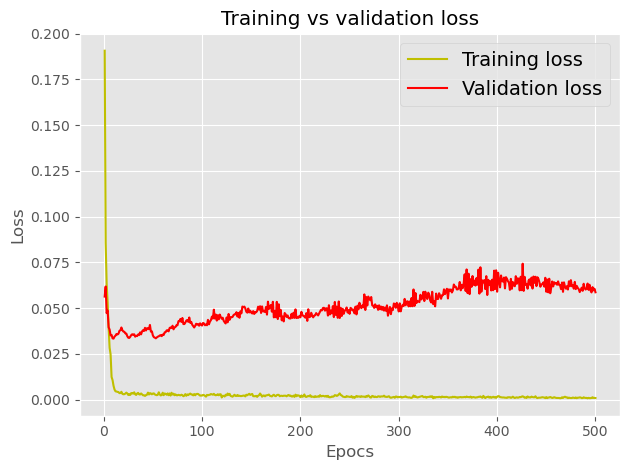

In [70]:
from matplotlib import pyplot as plt
loss = history.history['loss']
val_loss =history.history['val_loss']
epocs = range(1, len(loss) + 1)
plt.plot(epocs,loss, 'y', label = 'Training loss')
plt.plot(epocs, val_loss, 'r', label = 'Validation loss')
plt.title('Training vs validation loss')
plt.xlabel('Epocs')
plt.ylabel('Loss')
plt.style.use('ggplot')
plt.legend()
save_fig ("Training vs validation loss for dese layer")
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

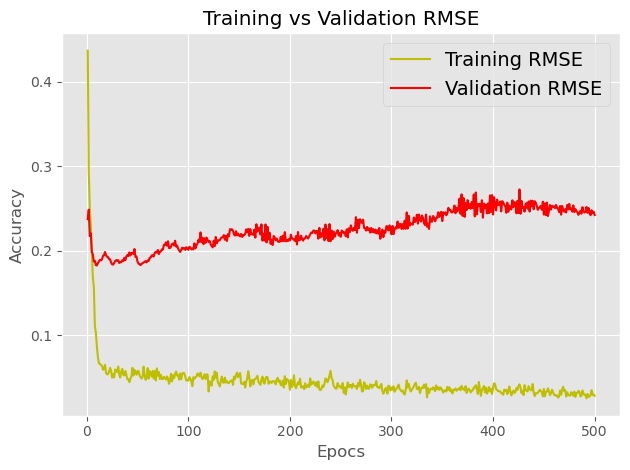

In [71]:
from matplotlib import pyplot as plt2
acc = history.history['root_mean_squared_error']
val_acc = history.history['val_root_mean_squared_error']
plt2.plot(epocs,acc, 'y', label = 'Training RMSE')
plt2.plot(epocs,val_acc, 'r', label = 'Validation RMSE')
plt2.title('Training vs Validation RMSE')
plt2.xlabel('Epocs')
plt2.ylabel('Accuracy')
plt2.style.use('ggplot')
plt2.legend()
save_fig ("Training vs Validation RMSE for dese layer")
plt2.show


### Prediction on test data

In [72]:
predictions = dmodel.predict(X_test[:15])
print("Predicted values are:", predictions)
print("Real values are: ", y_test[:15])

1/1 [==============================] - 0s 83ms/step
Predicted values are: [[0.7689496 ]
 [0.61233985]
 [0.56108224]
 [0.60960007]
 [0.62751496]
 [0.49475634]
 [0.4163418 ]
 [0.573704  ]
 [0.6427369 ]
 [0.7722536 ]
 [0.5790957 ]
 [0.76987714]
 [0.49855968]
 [0.6430459 ]
 [0.75140136]]
Real values are:  7      0.999990
157    0.005275
26     0.499028
53     0.455185
5      0.494815
43     0.498653
149    0.492884
33     0.496635
21     0.501449
69     0.492884
179    0.499409
11     0.498610
49     0.544764
130    0.498869
55     0.455424
Name: Expectation Values, dtype: float64


# LSTM

### Ignore Warning

In [73]:
import warnings
warnings.filterwarnings('ignore')

### Import libaray

In [74]:
from tensorflow.keras.layers import LSTM

### Reshaping the data for model

In [75]:
X_train = np.expand_dims(X_train, -1)
X_test =  x_train = np.expand_dims(X_test, -1)

In [76]:
X_train.shape

(115, 186, 1)

### Model creation

In [77]:
model = Sequential()
model.add(LSTM(128,input_shape = (X_train.shape[1],X_train.shape[2]), activation = 'relu',return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(64, activation = 'relu', return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(64, activation = 'relu', return_sequences=True))
model.add(LSTM(64, activation = 'relu', return_sequences=True))
model.add(LSTM(32, activation = 'relu', return_sequences=False))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer='adam' , metrics = [keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 186, 128)          66560     
                                                                 
 lstm_1 (LSTM)               (None, 186, 64)           49408     
                                                                 
 lstm_2 (LSTM)               (None, 186, 64)           33024     
                                                                 
 lstm_3 (LSTM)               (None, 186, 64)           33024     
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 194,465
Trainable params: 194,465
Non-tr

### Model evalution

In [78]:
history = model.fit(X_train,y_train, epochs=500, validation_data= (X_test,y_test))

Epoch 1/500
4/4 [==============================] - 11s 1s/step - loss: 0.3467 - root_mean_squared_error: 0.5888 - val_loss: 0.3051 - val_root_mean_squared_error: 0.5524
Epoch 2/500
4/4 [==============================] - 5s 1s/step - loss: 0.3152 - root_mean_squared_error: 0.5614 - val_loss: 0.2634 - val_root_mean_squared_error: 0.5132
Epoch 3/500
4/4 [==============================] - 4s 1s/step - loss: 0.2669 - root_mean_squared_error: 0.5166 - val_loss: 0.1886 - val_root_mean_squared_error: 0.4343
Epoch 4/500
4/4 [==============================] - 5s 1s/step - loss: 0.1694 - root_mean_squared_error: 0.4116 - val_loss: 0.0538 - val_root_mean_squared_error: 0.2319
Epoch 5/500
4/4 [==============================] - 5s 1s/step - loss: 0.1139 - root_mean_squared_error: 0.3375 - val_loss: 0.0506 - val_root_mean_squared_error: 0.2249
Epoch 6/500
4/4 [==============================] - 4s 1s/step - loss: 0.0804 - root_mean_squared_error: 0.2835 - val_loss: 0.0682 - val_root_mean_squared_error

### Plotting the result

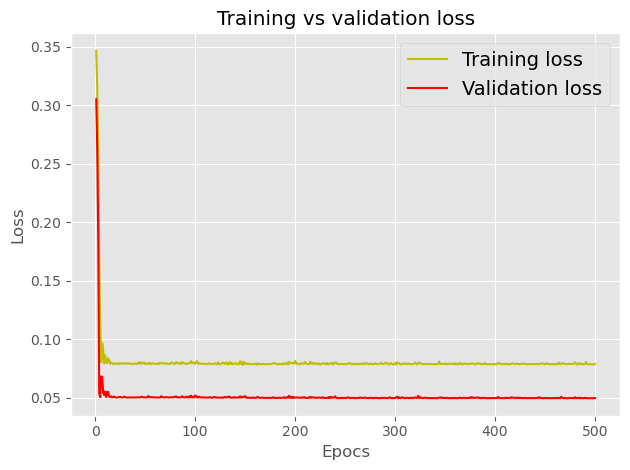

In [79]:
from matplotlib import pyplot as plt3
loss = history.history['loss']
val_loss =history.history['val_loss']
epocs = range(1, len(loss) + 1)
plt3.plot(epocs,loss, 'y', label = 'Training loss')
plt3.plot(epocs, val_loss, 'r', label = 'Validation loss')
plt3.title('Training vs validation loss')
plt3.xlabel('Epocs')
plt3.ylabel('Loss')
plt3.style.use('ggplot')
plt3.legend()
save_fig ("Training vs validation loss for LSTM")
plt3.show()

<function matplotlib.pyplot.show(close=None, block=None)>

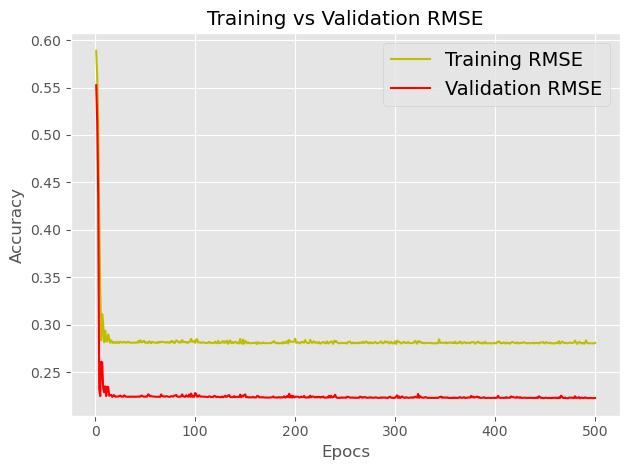

In [80]:
from matplotlib import pyplot as plt4
acc = history.history['root_mean_squared_error']
val_acc = history.history['val_root_mean_squared_error']
plt4.plot(epocs,acc, 'y', label = 'Training RMSE')
plt4.plot(epocs,val_acc, 'r', label = 'Validation RMSE')
plt4.title('Training vs Validation RMSE')
plt4.xlabel('Epocs')
plt4.ylabel('Accuracy')
plt4.style.use('ggplot')
plt4.legend()
save_fig ("Training vs Validation RMSE for LSTM")
plt4.show

### Prediction on test data

In [81]:
predictions = model.predict(X_test[:15])
print("Predicted values are:", predictions)
print("Real values are: ", y_test[:15])

1/1 [==============================] - 1s 842ms/step
Predicted values are: [[0.521728  ]
 [0.52191824]
 [0.52187544]
 [0.5401606 ]
 [0.5218669 ]
 [0.521843  ]
 [0.4905784 ]
 [0.52186924]
 [0.5218749 ]
 [0.5124567 ]
 [0.53155565]
 [0.5122641 ]
 [0.51059496]
 [0.5514848 ]
 [0.52999014]]
Real values are:  7      0.999990
157    0.005275
26     0.499028
53     0.455185
5      0.494815
43     0.498653
149    0.492884
33     0.496635
21     0.501449
69     0.492884
179    0.499409
11     0.498610
49     0.544764
130    0.498869
55     0.455424
Name: Expectation Values, dtype: float64


# Bi -LSTM

### Ignore Warning

In [82]:
import warnings
warnings.filterwarnings('ignore')

### Import libaray

In [83]:
import keras
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense

### Reshaping data for model

In [84]:
X_train = np.expand_dims(X_train, -1)
X_test =  x_train = np.expand_dims(X_test, -1)

### Model creation

In [85]:


bmodel = Sequential()
bmodel.add(LSTM(128,input_shape = (X_train.shape[1],X_train.shape[2]), activation = 'relu',return_sequences=True))
# model.add(Dropout(0.2))
bmodel.add(LSTM(64, activation = 'relu', return_sequences=True))
# model.add(Dropout(0.2))
bmodel.add(Bidirectional(LSTM(64, activation = 'relu', return_sequences=True)))
bmodel.add(Bidirectional(LSTM(64, activation = 'relu', return_sequences=True)))
bmodel.add(LSTM(32, activation = 'relu', return_sequences=False))
bmodel.add(Dense(1))
bmodel.compile(loss = 'mse', optimizer='adam' , metrics = [keras.metrics.RootMeanSquaredError()])
bmodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 186, 128)          66560     
                                                                 
 lstm_6 (LSTM)               (None, 186, 64)           49408     
                                                                 
 bidirectional (Bidirectiona  (None, 186, 128)         66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 186, 128)         98816     
 nal)                                                            
                                                                 
 lstm_9 (LSTM)               (None, 32)                20608     
                                                                 
 dense_4 (Dense)             (None, 1)                

### Model evalution

In [86]:
history = bmodel.fit(X_train,y_train, epochs=50, batch_size = 15,validation_data= (X_test,y_test))

Epoch 1/50
8/8 [==============================] - 19s 1s/step - loss: 0.2912 - root_mean_squared_error: 0.5396 - val_loss: 0.1216 - val_root_mean_squared_error: 0.3487
Epoch 2/50
8/8 [==============================] - 10s 1s/step - loss: 0.1163 - root_mean_squared_error: 0.3410 - val_loss: 0.0582 - val_root_mean_squared_error: 0.2412
Epoch 3/50
8/8 [==============================] - 10s 1s/step - loss: 0.0929 - root_mean_squared_error: 0.3048 - val_loss: 0.0592 - val_root_mean_squared_error: 0.2434
Epoch 4/50
8/8 [==============================] - 9s 1s/step - loss: 0.0782 - root_mean_squared_error: 0.2796 - val_loss: 0.0527 - val_root_mean_squared_error: 0.2296
Epoch 5/50
8/8 [==============================] - 11s 1s/step - loss: 0.0847 - root_mean_squared_error: 0.2910 - val_loss: 0.0501 - val_root_mean_squared_error: 0.2237
Epoch 6/50
8/8 [==============================] - 10s 1s/step - loss: 0.0828 - root_mean_squared_error: 0.2877 - val_loss: 0.0532 - val_root_mean_squared_error: 

### Plotting the result

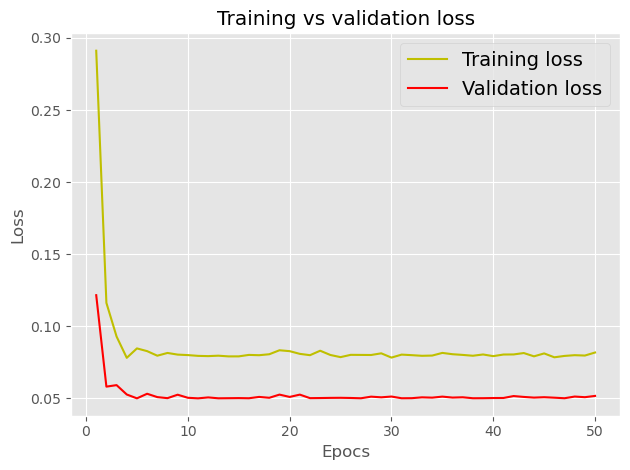

In [87]:
from matplotlib import pyplot as plt5
loss = history.history['loss']
val_loss =history.history['val_loss']
epocs = range(1, len(loss) + 1)
plt5.plot(epocs,loss, 'y', label = 'Training loss')
plt5.plot(epocs, val_loss, 'r', label = 'Validation loss')
plt5.title('Training vs validation loss')
plt5.xlabel('Epocs')
plt5.ylabel('Loss')
plt5.style.use('ggplot')
plt5.legend()
save_fig ("Training vs validation loss for BI-LSTM")
plt5.show()

<function matplotlib.pyplot.show(close=None, block=None)>

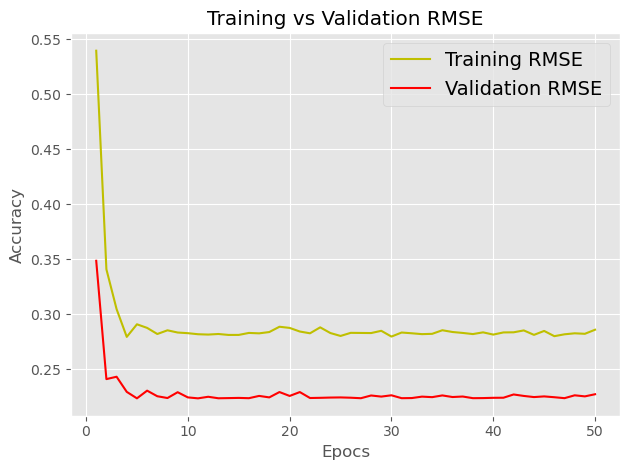

In [88]:
from matplotlib import pyplot as plt6
acc = history.history['root_mean_squared_error']
val_acc = history.history['val_root_mean_squared_error']
plt6.plot(epocs,acc, 'y', label = 'Training RMSE')
plt6.plot(epocs,val_acc, 'r', label = 'Validation RMSE')
plt6.title('Training vs Validation RMSE')
plt6.xlabel('Epocs')
plt6.ylabel('Accuracy')
plt6.style.use('ggplot')
plt6.legend()
save_fig ("Training vs Validation RMSE for for BI-LSTM")
plt6.show

### Prediction on test data

In [89]:
predictions = bmodel.predict(X_test[:15])
print("Predicted values are:", predictions)
print("Real values are: ", y_test[:15])

1/1 [==============================] - 1s 1s/step
Predicted values are: [[0.48924375]
 [0.48944312]
 [0.48939484]
 [0.49812692]
 [0.48938543]
 [0.48938802]
 [0.49203402]
 [0.48938802]
 [0.4893943 ]
 [0.48941356]
 [0.49364486]
 [0.48944372]
 [0.49474406]
 [0.498047  ]
 [0.49705544]]
Real values are:  7      0.999990
157    0.005275
26     0.499028
53     0.455185
5      0.494815
43     0.498653
149    0.492884
33     0.496635
21     0.501449
69     0.492884
179    0.499409
11     0.498610
49     0.544764
130    0.498869
55     0.455424
Name: Expectation Values, dtype: float64


# Feature Importance

In [90]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestRegressor
iris = load_iris(as_frame=True)
rf = RandomForestRegressor(n_estimators= 200, max_depth=500, random_state=0)

rf.fit(iris.data, iris.target)
for score, name in zip(rf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.01 sepal length (cm)
0.01 sepal width (cm)
0.48 petal length (cm)
0.51 petal width (cm)


In [91]:
rf.feature_importances_

array([0.00564135, 0.00721837, 0.48025529, 0.50688498])

# Save fig function

In [92]:
# Save figure function
import os
from pathlib import Path
from matplotlib import pyplot as plt
IMAGES_PATH = Path() / "IMAGES" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Explanation of the prediction using XAI 

### LIME

### Import libaray

In [93]:
import lime
import lime.lime_tabular
import numpy as np
import IPython
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

### Explainer

In [94]:

rf = RandomForestRegressor()
rf.fit(exp_X_train, y_train)


RandomForestRegressor()

In [95]:
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = exp_X_train.values,
    mode="regression",
    feature_names=exp_X_train.columns)

In [96]:
exp_X_test = np.array(exp_X_test)

In [97]:
restore = exp_X_test[0]

In [98]:
print(restore)

[0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

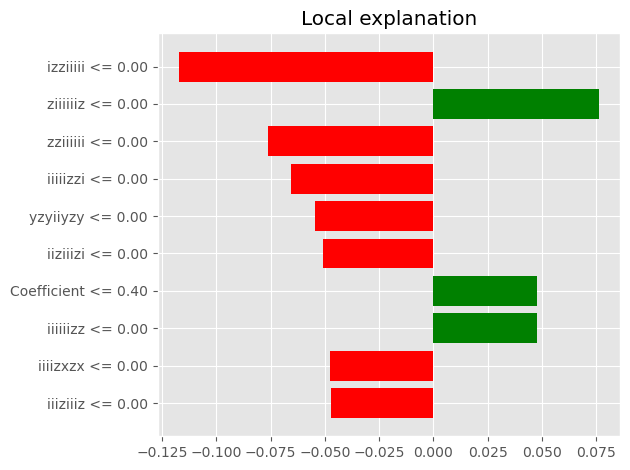

In [99]:
explanation = explainer.explain_instance(exp_X_test[0], rf.predict )
explanation
explanation.as_map()
explanation.as_pyplot_figure()
save_fig ("Lime XAI explanation of model prediction")

In [100]:
explanation.show_in_notebook(show_all=False)

In [101]:
pd.DataFrame(explanation.as_list(),columns=['Feature','Contribution'])

Feature  Contribution
0     izziiiii <= 0.00     -0.117336
1     ziiiiiiz <= 0.00      0.076222
2     zziiiiii <= 0.00     -0.076164
3     iiiiizzi <= 0.00     -0.065446
4     yzyiiyzy <= 0.00     -0.054652
5     iiziiizi <= 0.00     -0.050748
6  Coefficient <= 0.40      0.047842
7     iiiiiizz <= 0.00      0.047802
8     iiiizxzx <= 0.00     -0.047613
9     iiiziiiz <= 0.00     -0.047359

# SHARP

### Import libaray

In [102]:
import shap
import matplotlib.pyplot as plt7

### Explainer

In [103]:


# load JS visualization code to notebook
shap.initjs()

# Create the explainer
explainer = shap.TreeExplainer(rf)

shap_values = explainer.shap_values(exp_X_test)

XAI explanation of model prediction using sharp


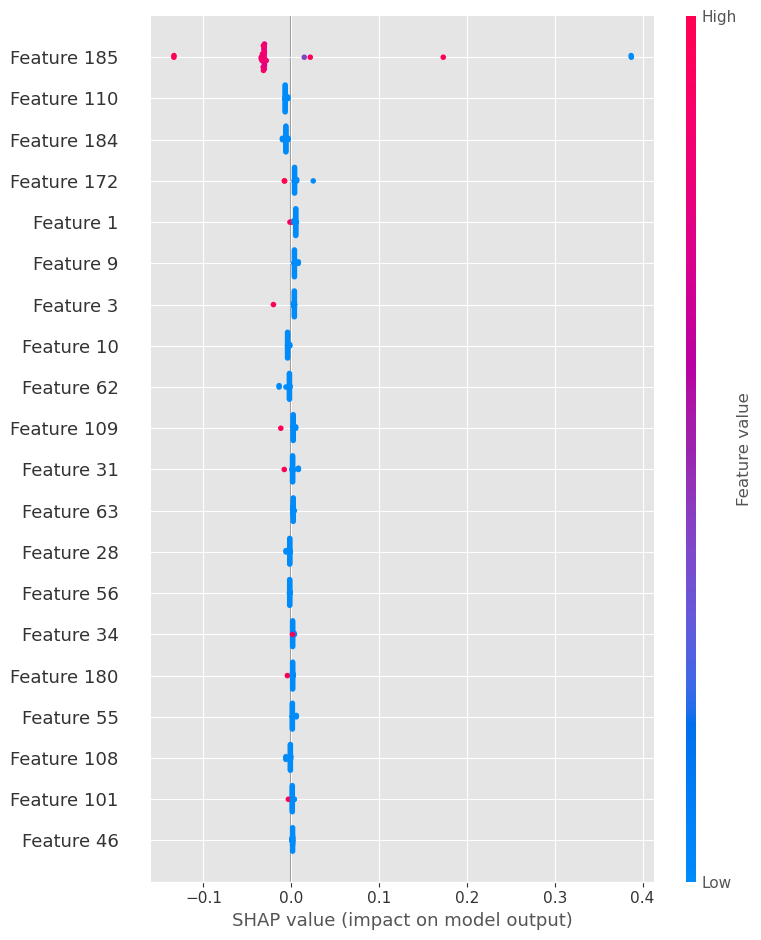

<Figure size 640x480 with 0 Axes>

In [104]:
print("XAI explanation of model prediction using sharp")
# figure = plt7.figure()
shap.summary_plot(shap_values, exp_X_test)
plt7.show()
save_fig ("SHARP XAI explanation of medel prediction")


# Decesion Tree

### Import libaray

In [105]:
from sklearn import tree

### Explainer

In [106]:
# Get the class names
class_names = exp_y_train

# Get the feature names
feature_names = list(exp_X_train.columns)

In [107]:
dtr = tree.DecisionTreeRegressor()


In [108]:
dtr.fit(exp_X_train, exp_y_train)

DecisionTreeRegressor()

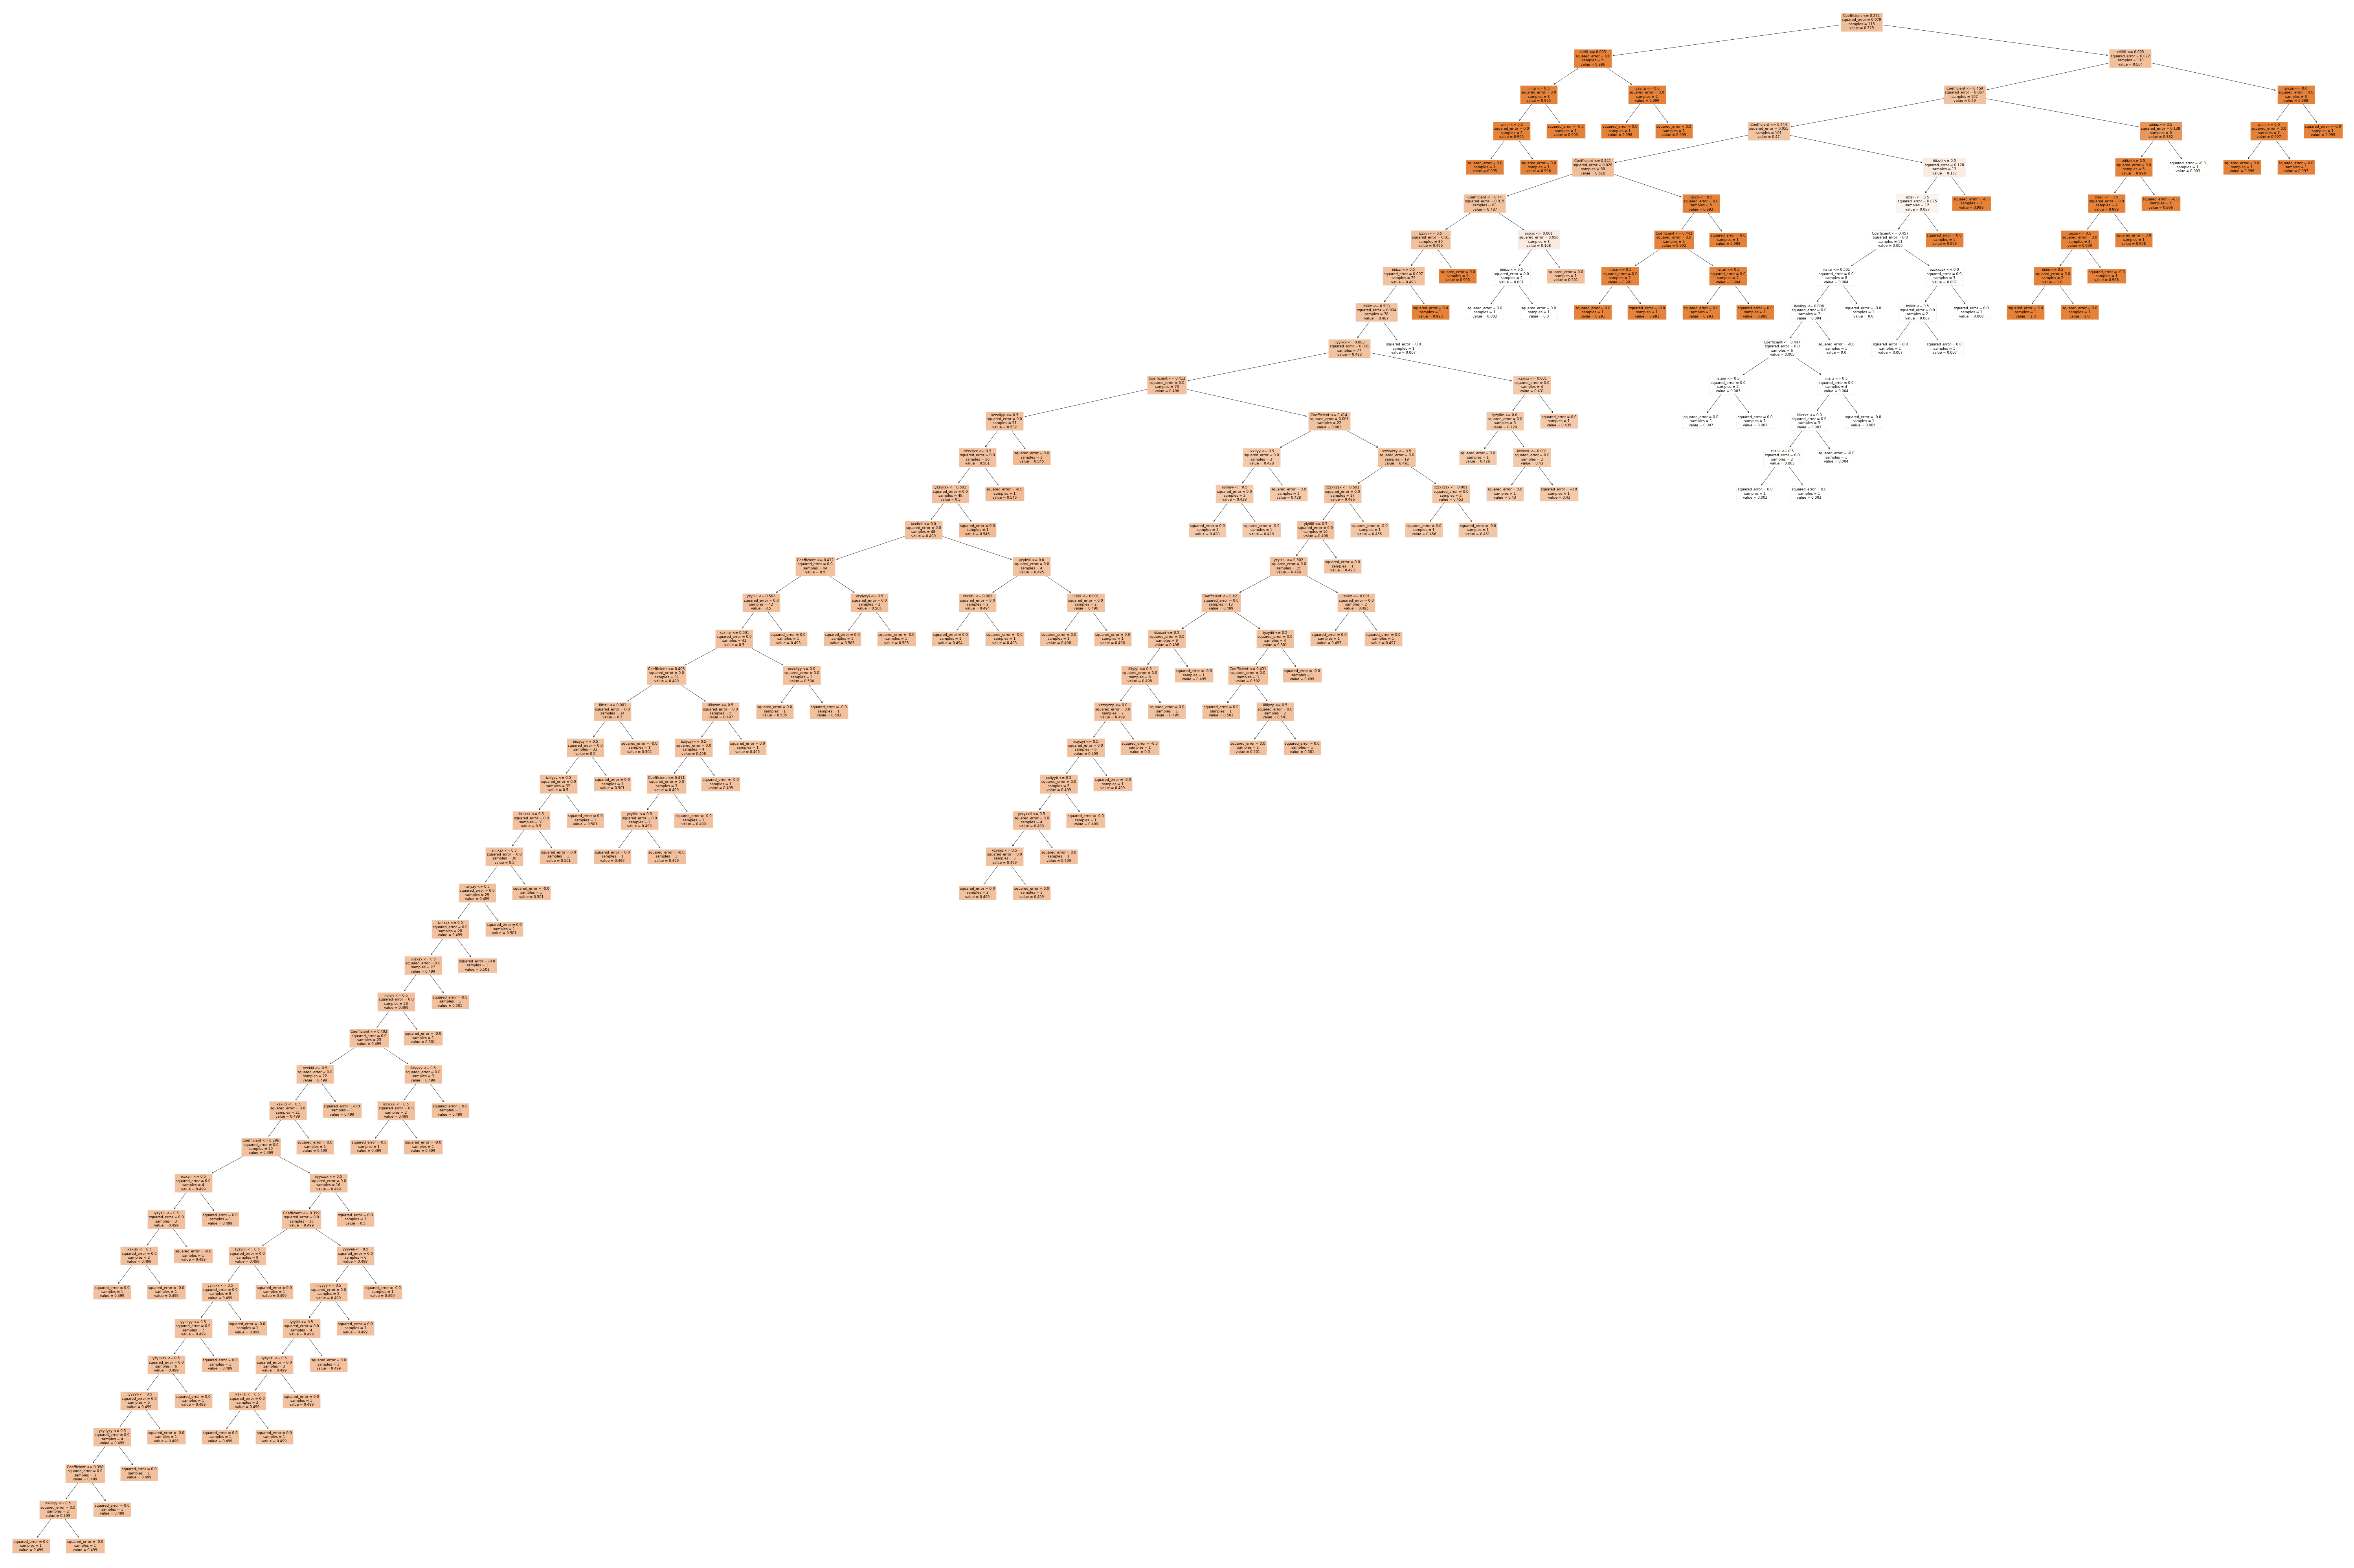

In [109]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(60,40))
_ = plot_tree(dtr,
               	feature_names = feature_names,
               	class_names = class_names,
               	filled=True)
save_fig ("Decesion tree explanation of model")